# Textual Data

In this notebook we will examine the distances between textual data. We are not going to use a dataset in this notebook. We will only use 3 sentences.

- Whoever has hate for his brother is in the darkness and walks in the darkness.
- Hello darkness, my old friend.
- Returning hate for hate multiplies hate, adding deeper darkness to a night devoid of stars. Darkness cannot drive out darkness; only light can do that.

In [3]:
import pandas as pd

docs = [
    "Whoever has hate for his brother is in the darkness and walks in the darkness.",
    "Hello darkness, my old friend.",
    "Returning hate for hate multiplies hate, adding deeper darkness to a night devoid of stars. Darkness cannot drive out darkness; only light can do that."
]

Let's check what happens when we check distances using Euclidean distance with the documents

In [14]:
from collections import Counter
import string
import pandas as pd

vocab = ["darkness", "hate"]

def count_word_counter(doc, word):
    tokens = [t.strip(string.punctuation) for t in doc.lower().split()]
    return Counter(tokens)[word]

def count_word_pd(doc, word):
    tokens = [t.strip(string.punctuation) for t in doc.lower().split()]
    return pd.Series.value_counts().get(word, 0)

rows = []
for doc in docs:
    # use count_word_counter or count_word_pd interchangeably
    rows.append({w: count_word_counter(doc, w) for w in vocab})

df = pd.DataFrame(rows)
df.index.name = "doc"
print("Feature counts (darkness, hate):")
display(df)

Feature counts (darkness, hate):


,darkness,hate
doc,,
0,2,1
1,1,0
2,3,3


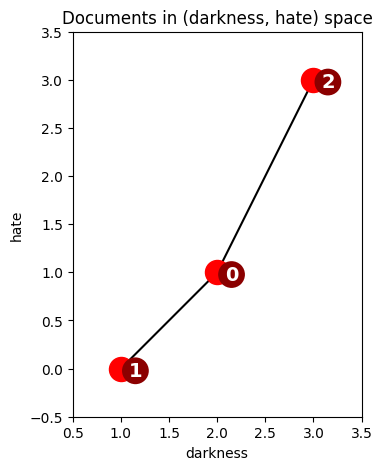

In [5]:
import matplotlib.pyplot as plt

x = df["darkness"].values
y = df["hate"].values

plt.figure(figsize=(5,5))
plt.scatter(x, y, c="red", s=300, zorder=3)
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi + 0.08, yi - 0.08, str(i), fontsize=14, fontweight="bold", color="white",
             bbox=dict(facecolor="darkred", edgecolor="none", boxstyle="circle,pad=0.2"))

# connect in order 1 -> 0 -> 2
order = [1, 0, 2]
plt.plot(x[order], y[order], color="black", linewidth=1.5, zorder=2)

plt.xlabel("darkness")
plt.ylabel("hate")
plt.title("Documents in (darkness, hate) space")
plt.xlim(min(x) - 0.5, max(x) + 0.5)
plt.ylim(min(y) - 0.5, max(y) + 0.5)
plt.grid(False)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

## Vector Space Model

In **VSM**, documents are represented as *vectors* instead of points.

The length of a vector is its distance from the origin 0.

$$
||v|| = \sum_{i=1}^n v_i^2
$$

The distance between two vectors corresponds to the angle between them:

$$
d(x, x') = 1 - cosΘ
$$

$$=$$

$$
\sum_{j=1}^n x_jx'_j \over ||x|| ||x'||
$$

**Cosine distance** measures the similarity or difference between two vectors.


It is based on the **angle** between the vectors, the more aligned their directions, the more similar they are.

`Cosine distance = 1 - cosine similarity` shows the difference
- 0 -> very similar
- 1 -> compeletely different.

#### VSM with Pandas

In [17]:
import pandas as pd
from collections import Counter

tf = pd.DataFrame(
    [Counter(doc.split()) for doc in docs]
).fillna(0)

tf

,Whoever,has,hate,for,his,brother,is,in,the,darkness,...,Darkness,cannot,drive,out,darkness;,only,light,can,do,that.
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [21]:
import numpy as np

def length(v):
    return np.sqrt((v ** 2).sum())

def cos_dist(v, w):
    return 1 - (v * w).sum() / (length(v) * length(w))

print(f"Distance between x0 and x1:{cos_dist(tf.loc[0], tf.loc[1])}")
print(f"Distance between x0 and x2:{cos_dist(tf.loc[0], tf.loc[2])}")

Distance between x0 and x1:1.0
Distance between x0 and x2:0.8233956857246608


#### VSM in Scikit-Learn

It is always easier to do it in Scikit-Learn

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(token_pattern=r"\w+")
vec.fit(docs)
tf_matrix = vec.transform(docs)
tf_matrix.todense()

matrix([[0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
         1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 3, 0, 0, 0, 0, 1, 1,
         0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]])

In [24]:
from sklearn.metrics import pairwise_distances

pairwise_distances(tf_matrix[0, :], tf_matrix, metric="cosine")


array([[0.        , 0.80481999, 0.641252  ]])

A smaller cosine distance means higher similarity.

The first document is most similar to the thir one (0.64...)

## tf-idf: Term Frequency - Inverse Document Frequency

In other methods we simply counted the **term frequency**.

**The problem about this:** Common words like "is" or "the" tend to dominate because they have high counts.

- **tf(d,t):** how many times each term $t$ appears in each document $d$

- **idf(t, D):** how rare the word is across all documents.

- If the TF-IDF value is high -> The word is unique to that document and carries strong disinguishing meaning.

- If a words appears in every document -> df(t, D)$\approx$ |D| -> $log(1) = 0$ -> $idf \approx 0$
  - This word has no discriminative power (it is unimportant)


- If a word appears in every document -> df is *small* -> $|D|/df$ is large -> log is large -> idf is high
  - This word is important for distinguishing between documents.


**How tf-idf works**:

1. Count the fraction of documents the term appears in:

$$
df(t, D) = 
\frac{\# \text{ documents containing term } t}{\# \text{ documents}}
= 
\frac{|\{ d \in D : t \in d \}|}{|D|}
$$

2. Invert and take a log to obtain **inverse document frequency**:

$$
idf(t, D) = 1 + \log \frac{1}{df(t, D)}
$$

3. Multiply tf by idf to get tf-idf:

$$
\text{tf-idf}(d, t, D) = tf(d, t) \cdot idf(t, D)
$$


Now we can use the **tf-idf matrix** just like we used the term-frequency matrix.

**Let's calculate the tf-idf matrix for "darkness" and "hate"**:

1. Calculate the document frequencies:

$$
df("darkness", D) = \frac{3}{3} = 1 
\qquad 
df("hate", D) = \frac{2}{3}
$$

2. Calculate the inverse document frequencies:

$$
idf("darkness", D) = 1 + \log 1 = 1 
\qquad 
idf("hate", D) = 1 + \log \frac{3}{2} \approx 1.176
$$


3. Multiply $tf$ by $idf$ to get **tf-idf**:

$$
\begin{array}{c|cc}
 & \text{darkness} & \text{hate} \\
\hline
0 & 2 & 1.176 \\
1 & 1 & 0 \\
2 & 3 & 3.528 \\
\end{array}
$$


### tf-idf in Scikit-Learn

- `TfidVectorizer` -> Class for converting text into tf-idf features.
- `smooth_idf=false` -> uses the exact idf formula (no smoothing).
- `norm=None`-> Does not normalize the vectors.
- `vec.fit(documents)` -> Learns the vocabulary and computes idf values from all documents.
- `vec.transform(documents)` -> Converts each document into a tf-idf weighted vector, based on the learned vocabulary.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# The options ensure that the numbers match our example above.
vec = TfidfVectorizer(smooth_idf=False, norm=None)
vec.fit(docs)
tfidf_matrix = vec.transform(docs)

tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 37 stored elements and shape (3, 33)>

In [28]:
print(f"Distances with x0: {pairwise_distances(tfidf_matrix[0, :], tfidf_matrix, metric="cosine")}")

Distances with x0: [[0.         0.94612045 0.8412657 ]]
